## Devito CFD Tutorial series

The following series of notebook tutorials will demonstrate the use of Devito and it's SymPy-based API to solve a set of classic examples from Computational Fluid Dynamics (CFD). The tutorials are based on the excellent tutorial series _CFD Python: 12 steps to Navier-Stokes_ by Lorena Barba and focus on the implementation with Devito rather than pure CFD or finite difference theory. For a refresher on how to implement 2D finite difference solvers for CFD problems, please see the original tutorial series here: <br>
http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/

### Example 1: Linear convection in 2D

Lets start with a simple 2D convection example - step 5 in the original blog. This will already allow us to demonstrate a lot about the use of Devito's symbolic data objects and how to use them to build a simple operator directly from the symbolic notation of the equation. The governing equation we will implement in this tutorial is:

$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0$$

In order to implement this equation we first discretize it using forward differences in time and backward differences in space. Just as the original tutorial, we will use $u_{i,j}^n$ to denote a finite difference stencil point with $i$ and $j$ denoting spatial indices and $n$ denoting the time index. So, after re-arranging the discretized equation for the forward stencil point in time we get 

$$u_{i,j}^{n+1} = u_{i,j}^n-c \frac{\Delta t}{\Delta x}(u_{i,j}^n-u_{i-1,j}^n)-c \frac{\Delta t}{\Delta y}(u_{i,j}^n-u_{i,j-1}^n)$$

Using this, we can start deriving the computational stencil for this equation. Let's first look at the original _pure Python_ implementation of the linear convection flow - but first we import our tools and define some parameters:

In [1]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 81
ny = 81
nt = 100
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
print("dx %s, dy %s" % (dx, dy))
sigma = .2
dt = sigma * dx

dx 0.025, dy 0.025


**A small note on style:** Throughout this tutorial series we will use utility functions to plot the various 2D functions and data sets we deal with. These are all taken from the original tutorial series, but have been slightly modified for our purposes. One of the differences readers might find is that the original series uses _(y, x)_ indexing for 2d data arrays, whereas many of the examples have been adapted to use _(x, y)_ notation in our tutorials.

So, let's start by creating a simple 2D function and initialising it with a "hat function". We will use that initialisation function a lot, so it comes from our utility scripts:

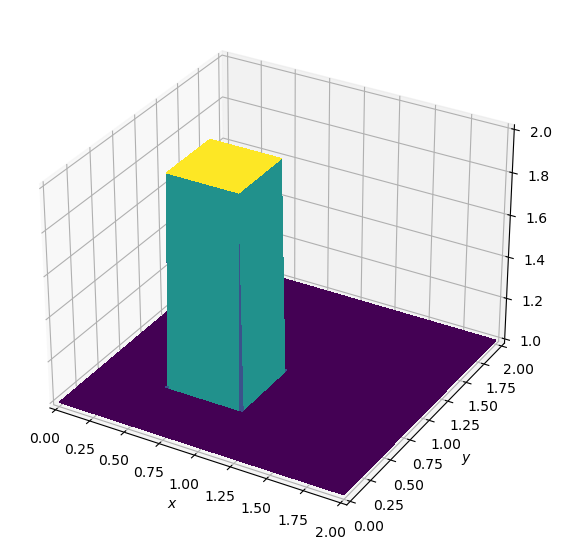

In [2]:
#NBVAL_IGNORE_OUTPUT

# Create field and assign initial conditions
u = np.empty((nx, ny))
init_hat(field=u, dx=dx, dy=dy, value=2.)

# Plot initial condition
plot_field(u)

Now we can repeat the _pure NumPy_ solve from the original tutorial, where we use NumPy array operations to speed up the computation. Note that we skip the derivation of the stencil used to implement our convection equation, as we are going to walk though this process using the Devito API later in this tutorial.

In [3]:
# Repeat initialisation, so we can re-run the cell
init_hat(field=u, dx=dx, dy=dy, value=2.)

for n in range(nt + 1):
    # Copy previous result into a new buffer
    un = u.copy()
    
    # Update the new result with a 3-point stencil
    u[1:, 1:] = (un[1:, 1:] - (c * dt / dy * (un[1:, 1:] - un[1:, :-1])) -
                              (c * dt / dx * (un[1:, 1:] - un[:-1, 1:])))

    # Apply boundary conditions. 
    u[0, :] = 1.  # left
    u[-1, :] = 1. # right
    u[:, 0] = 1.  # bottom
    u[:, -1] = 1. # top
    # Note that in the above expressions the NumPy index -1 corresponds to the final point of the array along the indexed dimension, 
    #    i.e. here u[-1, :] is equivalent to u[80, :].


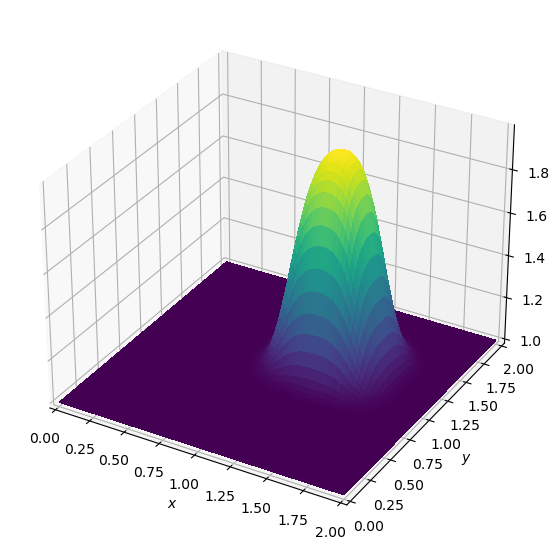

In [4]:
#NBVAL_IGNORE_OUTPUT

# A small sanity check for auto-testing
assert (u[45:55, 45:55] > 1.8).all()
u_ref = u.copy()

plot_field(u)

Hooray, the wave moved! Now, this little example is already very concise from a notational point of view and it teaches us quite a few key points about how to perform finite difference stencil computation via NumPy:
* Due to the backward differencing scheme in space (more later) we use only three stencil point in this example:  $u^{n}_{i, j}$, $u^{n}_{i-1, j}$ and $u^{n}_{i, j-1}$. These can be identified in the code through the array indices and correspond to `un[1:, 1:]`, `un[:-1, 1:]` and `un[1:, :-1]` respectively. 
* Two buffers for array data are used throughout: `un[...]` is read from, while `u[...]` is updated, where the line `un = u.copy()` performs a deep copy of the field to switch buffers between timesteps. Note that in some other finite difference tutorials the cost of this copy operation is sometimes amortised by using two pre-allocated buffers and switching the indices of them explicitly.   
* The final four lines within the loop code show us how to implement simple Dirichlet boundary condition by simply setting a value on the outermost rows and columns of our cartesian grid.

You may have noticed that the hat has not only moved to a different location, but has also changed its shape into a smooth bump. This is a little surprising, as the correct solution of the convection equation would be movement without shape change. The smooth shape is caused by numerical diffusion, a well-known limitation of low-order finite difference schemes. We will discuss this issue and some solutions later in this tutorial.

#### Devito implementation
Now we want to re-create the above example via a Devito operator. To do this, we can start by defining our computational grid and creating a function `u` as a symbolic `devito.TimeFunction`. The core thing to note here is that this is one of Devito's symbolic functions, which have a dual role in the creation of finite difference solvers:
* They behave symbolically like `sympy.Function` objects, so that we can construct derivatives and use them in symbolic expressions, thus inheriting all the power of automated symbolic manipulation that SymPy provides.
* They act as containers for user data by providing a `.data` property that wraps automatically allocated memory space in a neat NumPy array.

The particular `TimeFunction` type that we will declare our variable $u$ as in this case is aware of the fact that we will want to implement a timestepping algorithm with it. So the object `u` will declare two buffers of shape `(nx, ny)` for us, as defined by the `Grid` object, and present them as `u.data[0]` and `u.data[1]`. Let's fill the initial buffer with some data and look at it:

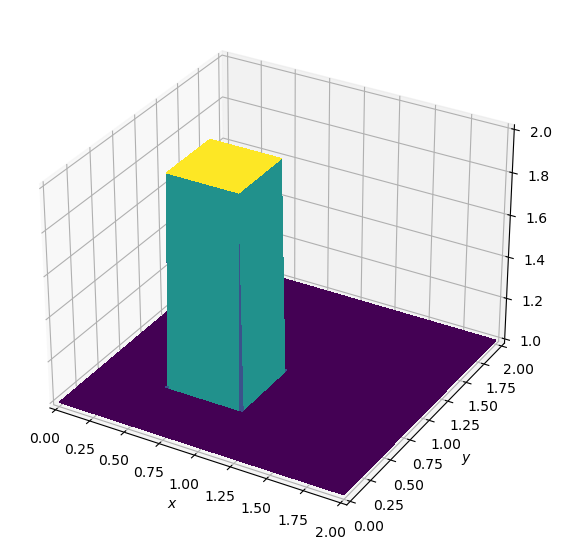

In [5]:
#NBVAL_IGNORE_OUTPUT
from devito import Grid, TimeFunction

grid = Grid(shape=(nx, ny), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)
# Note u.data[0] == u.data[0,:,:]
plot_field(u.data[0])

Nice. Now we can look at deriving our 3-point stencil using the symbolic capabilities given to our function $u$ by SymPy. For this we will first construct our derivative terms in space and time. For the forward derivative in time we can easily use Devito's shorthand notation `u.dt` to denote the first derivative in time and `u.dxl` and `u.dyl` to denote the space derivatives. Note that the `l` means were using the "left" or backward difference here to adhere to the discretization used in the original tutorials.

From the resulting terms we can then create a `sympy.Equation` object that contains the fully discretized equation, but from a neat high-level notation, as shown below.

In [6]:
from devito import Eq

# Specify the `interior` flag so that the stencil is only
# applied to the interior of the domain.
eq = Eq(u.dt + c*u.dxl + c*u.dyl, subdomain=grid.interior)

print(eq)

Eq(Derivative(u(t, x, y), x) + Derivative(u(t, x, y), y) + Derivative(u(t, x, y), t), 0)


The above step resulted in a fully discretized version of our equation, which includes place-holder symbols for the spacing in time (`dt`) and space (`h`). These symbols are based on an internal convention and will later be replaced when we build an operator.

But before we can build an operator, we first need to change our discretized expression so that we are updating the forward stencil point in our timestepping scheme - Devito provides another short-hand notation for this: `u.forward`. For the actual symbolic reordering, SymPy comes to the rescue with the `solve` utility that we can use to re-organise our equation.

In [7]:
from devito import solve
from sympy import nsimplify, pprint

stencil = solve(eq, u.forward)

# nsimplify: 1.0*x = x
pprint(nsimplify(stencil))

   ⎛  ∂                ∂                u(t, x, y)⎞
dt⋅⎜- ──(u(t, x, y)) - ──(u(t, x, y)) + ──────────⎟
   ⎝  ∂x               ∂y                   dt    ⎠


The careful reader will note that this is equivalent to the symbolic expression for the RHS of the NumPy code we showed earlier - only with `dx` and `dy` denoted as `h_x` and `h_y` respectively, while `u(t, x, y)`, `u(t, x - h, y)` and `u(t, x, y - h)` denote the equivalent of $u^{n}_{i, j}$, $u^{n}_{i-1, j}$ and $u^{n}_{i, j-1}$ analytically and `u[1:, 1:]`, `u[:-1, 1:]` and `u[1:, :-1]` in the numpy implementation respectively. 

We can now use this stencil expression to create an operator to apply to our data object:

Operator `Kernel` ran in 0.01 s


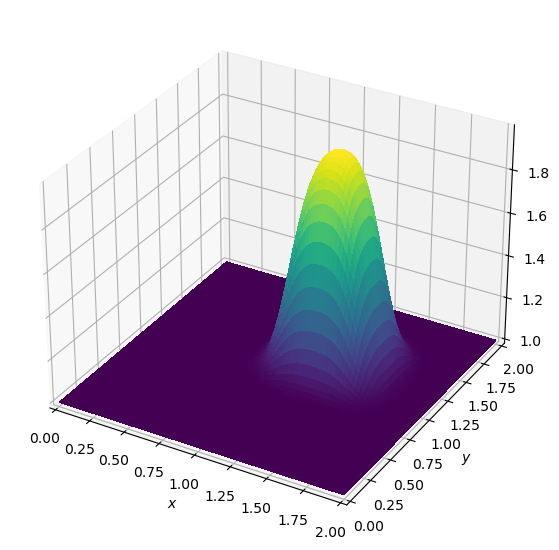

In [8]:
#NBVAL_IGNORE_OUTPUT
from devito import Operator

# Reset our initial condition in both buffers.
# This is required to avoid 0s propagating into
# our solution, which has a background value of 1.
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)
init_hat(field=u.data[1], dx=dx, dy=dy, value=2.)

# Create an operator that updates the forward stencil point
op = Operator(Eq(u.forward, stencil, subdomain=grid.interior))

# Apply the operator for a number of timesteps
op(time=nt, dt=dt)

plot_field(u.data[0, :, :])

# Some small sanity checks for the testing framework
assert (u.data[0, 45:55, 45:55] > 1.8).all()
assert np.allclose(u.data[0], u_ref, rtol=3.e-2)

Great, that looks to have done the same thing as the original NumPy example, so we seem to be doing something right, at least.

**A note on performance:** During the code generation phase of the previous operator Devito has introduced several performance optimisations. We will ignore this aspect for now, also because our example is tiny - but for large runs where performance matters, these optimisations will make a Devito kernel run very fast in comparison to raw Python/NumPy.

Now, despite getting a correct looking result, there is still one problem with the above operator: It doesn't set any boundary conditions as part of the time loop. We also note that the operator includes a time loop, but at this point Devito doesn't actually provide any language constructs to explicitly define different types of boundary conditions (Devito is probably still a kind of prototype at this point). Luckily though, Devito provides a backdoor for us to insert custom expression in the so-called "indexed" or "low-level" API that allow us to encode the Dirichlet boundary condition of the original example.

#### The "indexed" or low-level API
The `TimeFunction` field we created earlier behaves symbolically like a `sympy.Function` object with the appropriate indices, eg. `u(t, x, y)`. If we take a simple first-order derivative of that we have a term that includes the spacing variable `h`, which Devito uses as the default for encoding $dx$ or $dy$. For example, `u.dx` simply expands to `-u(t, x, y)/h + u(t, x + h, y)/h`.

Now, when the `Operator` creates explicit C-code from that expression, it at some point "lowers" that expression by resolving explicit data accesses (or indices) into our grid by transforming it into a `sympy.Indexed` object. During this process all occurrences of `h` in data accesses get replaced with integers, so that the expression now looks like `-u[t, x, y]/h + u[t, x + 1, y]/h`. This is the "indexed" notation and we can create custom expression of the same kind by explicitly writing `u[...]`, that is with indices in square-bracket notation. These custom expressions can then be injected into our operator like this:

Operator `Kernel` ran in 0.01 s


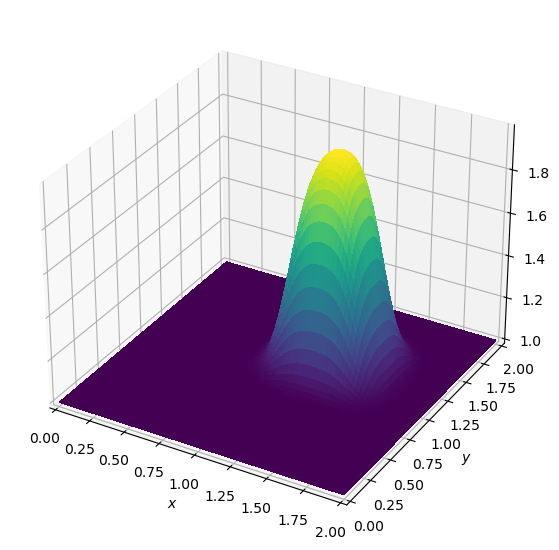

In [9]:
#NBVAL_IGNORE_OUTPUT

# Reset our data field and ICs in both buffers
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)
init_hat(field=u.data[1], dx=dx, dy=dy, value=2.)

# For defining BCs, we want to explicitly set rows/columns in our field
# We can use Devito's "indexed" notation to do this:
x, y = grid.dimensions
t = grid.stepping_dim
bc_left = Eq(u[t + 1, 0, y], 1.)
bc_right = Eq(u[t + 1, nx-1, y], 1.)
bc_top = Eq(u[t + 1, x, ny-1], 1.)
bc_bottom = Eq(u[t + 1, x, 0], 1.)

# Now combine the BC expressions with the stencil to form operator
expressions = [Eq(u.forward, stencil)]
expressions += [bc_left, bc_right, bc_top, bc_bottom]
op = Operator(expressions=expressions, opt=None, openmp=False)  # <-- Turn off performance optimisations
op(time=nt, dt=dt)

plot_field(u.data[0])

# Some small sanity checks for the testing framework
assert (u.data[0, 45:55, 45:55] > 1.8).all()
assert np.allclose(u.data[0], u_ref, rtol=3.e-2)

You might have noticed that we used the argument `opt=None` in the creation of the previous operator. This suppresses the various performance optimisation steps in the code-generation pipeline, which makes the auto-generated C code much easier to look at. So, for the brave, let's have a little peek under the hood... 

In [10]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;

  for (int time = time_m, t0 = (time)%(2), t1 = (time + 1)%(2